In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
data = pd.read_csv('jnj_long_data.csv')

In [4]:
data

,Date,Close,High,Low,Open,Volume
0,1962-01-02,0.062519,0.062519,0.062195,0.000000,0
1,1962-01-03,0.061547,0.061871,0.061547,0.000000,345600
2,1962-01-04,0.060899,0.061871,0.060899,0.000000,216000
3,1962-01-05,0.059927,0.060413,0.059927,0.000000,129600
4,1962-01-08,0.058956,0.059441,0.058956,0.000000,172800
...,...,...,...,...,...,...
15870,2025-01-22,145.270004,145.470001,142.110001,144.000000,16834700
15871,2025-01-23,146.639999,147.910004,144.809998,145.440002,10506400
15872,2025-01-24,146.820007,147.630005,146.380005,146.809998,9887300
15873,2025-01-27,152.889999,153.449997,148.000000,148.449997,15152300


,Date,Close,High,Low,Open,Volume
0,1962-01-02,0.062519,0.062519,0.062195,0.000000,0
1,1962-01-03,0.061547,0.061871,0.061547,0.000000,345600
2,1962-01-04,0.060899,0.061871,0.060899,0.000000,216000
3,1962-01-05,0.059927,0.060413,0.059927,0.000000,129600
4,1962-01-08,0.058956,0.059441,0.058956,0.000000,172800
...,...,...,...,...,...,...
15870,2025-01-22,145.270004,145.470001,142.110001,144.000000,16834700
15871,2025-01-23,146.639999,147.910004,144.809998,145.440002,10506400
15872,2025-01-24,146.820007,147.630005,146.380005,146.809998,9887300
15873,2025-01-27,152.889999,153.449997,148.000000,148.449997,15152300


In [6]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [7]:
data

,Close,High,Low,Open,Volume
Date,,,,,
1962-01-02,0.062519,0.062519,0.062195,0.000000,0
1962-01-03,0.061547,0.061871,0.061547,0.000000,345600
1962-01-04,0.060899,0.061871,0.060899,0.000000,216000
1962-01-05,0.059927,0.060413,0.059927,0.000000,129600
1962-01-08,0.058956,0.059441,0.058956,0.000000,172800
...,...,...,...,...,...
2025-01-22,145.270004,145.470001,142.110001,144.000000,16834700
2025-01-23,146.639999,147.910004,144.809998,145.440002,10506400
2025-01-24,146.820007,147.630005,146.380005,146.809998,9887300


In [8]:
# check the frequency
print(data.index.freq)

None


In [9]:
# Set the frequency to daily
data = data.resample('D').ffill()

In [10]:
print(data.index.freq)

<Day>


In [11]:
# check for missing
data.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


## Stationarity Check

In [12]:
# Perform ADF test
result = adfuller(data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpret the result
if result[1] <= 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")

ADF Statistic: 1.6133005025545801
p-value: 0.9978969350141512
Critical Values:
   1%: -3.4306344233350767
   5%: -2.8616657060194277
   10%: -2.5668369097226367
The data is non-stationary (fail to reject the null hypothesis).


In [13]:
# Apply differencing
data['Close_diff'] = data['Close'].diff().dropna()

In [14]:
data

,Close,High,Low,Open,Volume,Close_diff
Date,,,,,,
1962-01-02,0.062519,0.062519,0.062195,0.000000,0,NaN
1962-01-03,0.061547,0.061871,0.061547,0.000000,345600,-0.000972
1962-01-04,0.060899,0.061871,0.060899,0.000000,216000,-0.000648
1962-01-05,0.059927,0.060413,0.059927,0.000000,129600,-0.000972
1962-01-06,0.059927,0.060413,0.059927,0.000000,129600,0.000000
...,...,...,...,...,...,...
2025-01-24,146.820007,147.630005,146.380005,146.809998,9887300,0.180008
2025-01-25,146.820007,147.630005,146.380005,146.809998,9887300,0.000000
2025-01-26,146.820007,147.630005,146.380005,146.809998,9887300,0.000000


In [15]:
# drop Na from close_diff
data.dropna(inplace=True)

In [16]:
# Use only the 'Close_diff' column
data = data[['Close_diff']]

In [17]:
data

,Close_diff
Date,
1962-01-03,-0.000972
1962-01-04,-0.000648
1962-01-05,-0.000972
1962-01-06,0.000000
1962-01-07,0.000000
...,...
2025-01-24,0.180008
2025-01-25,0.000000
2025-01-26,0.000000


## Train-Test split

In [18]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Models

## ARIMA

### Determine ARIMA Parameters:

In [19]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.4 MB/s eta 0:00:00


In [20]:
from pmdarima import auto_arima

model_arima = auto_arima(train['Close_diff'], seasonal=False, trace=True)
print(model_arima.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-9091.697, Time=6.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-9022.372, Time=1.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-9021.127, Time=0.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-9021.183, Time=1.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-9084.211, Time=6.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-9039.999, Time=3.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-9089.698, Time=10.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-9089.967, Time=18.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-9075.494, Time=7.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-9082.697, Time=8.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-9037.979, Time=1.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-9154.112, Time=25.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-9137.165, Time=26.95 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-9151.608, Time=28.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-9116.230, Time=14.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-9116.770, Time=20.95 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,4)(0,0,0)[0]             : AIC=-9166.569, Time=40.59 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(0,0,0)[0]             : AIC=inf, Time=58.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,5)(0,0,0)[0]             : AIC=-9169.184, Time=35.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,5)(0,0,0)[0]             : AIC=-9161.451, Time=31.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,5)(0,0,0)[0]             : AIC=-9170.719, Time=40.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,5)(0,0,0)[0] intercept   : AIC=-9167.530, Time=108.99 sec

Best model:  ARIMA(5,0,5)(0,0,0)[0]          
Total fit time: 497.948 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                18429
Model:               SARIMAX(5, 0, 5)   Log Likelihood                4596.360
Date:                Wed, 05 Feb 2025   AIC                          -9170.719
Time:                        09:29:36   BIC                          -9084.681
Sample:                    01-03-1962   HQIC                         -9142.458
                         - 06-17-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1911      0.198      0.967      0.333      -0

# Fit ARIMA Model:

In [21]:
model = ARIMA(train['Close_diff'], order=(5, 0, 5))
fitted_model = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Forecaast and Evaluate

In [35]:
# Generate forecasts using the fitted ARIMA model
arima_forecast = fitted_model.predict(start=test.index[0], end=test.index[-1])

mae_arima = mean_absolute_error(test['Close_diff'], arima_forecast)
# Calculate MSE first, then take the square root for RMSE
mse_arima = mean_squared_error(test['Close_diff'], arima_forecast)
rmse_arima = np.sqrt(mse_arima)  # Calculate RMSE using NumPy
print(f'ARIMA MAE: {mae_arima}, RMSE: {rmse_arima}')

ARIMA MAE: 0.5855675891074118, RMSE: 1.080379419647628


# LSTM Model

## Preprocess Data for LSTM

In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[['Close_diff']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(scaled_train, seq_length)

## Build LSTM Model:

In [23]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train LSTM Model

In [24]:
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - loss: 0.0131
Epoch 2/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - loss: 5.1168e-04
Epoch 3/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - loss: 5.0273e-04
Epoch 4/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - loss: 5.5892e-04
Epoch 5/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - loss: 6.0063e-04
Epoch 6/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - loss: 5.7031e-04
Epoch 7/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 37s 65ms/step - loss: 6.1995e-04
Epoch 8/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 38s 66ms/step - loss: 5.1556e-04
Epoch 9/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - loss: 5.4915e-04
Epoch 10/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - loss: 5.3532e-04


## Forecast and Evaluate

In [25]:
scaled_test = scaler.transform(test[['Close_diff']])
X_test, y_test = create_sequences(scaled_test, seq_length)
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

#mae = mean_absolute_error(test['Close_diff'].iloc[seq_length:], predictions)
#print('LSTM MAE:', mae)

143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


In [27]:
mae_lstm = mean_absolute_error(test[seq_length:], predictions)
rmse_lstm = np.sqrt(mean_squared_error(test[seq_length:], predictions))
print(f'LSTM MAE: {mae_lstm}, RMSE: {rmse_lstm}')

LSTM MAE: 0.7058339715003967, RMSE: 1.1228640200152302


# Prophet Model

## Prepare Data for Prophet

In [28]:
train_prophet = train.reset_index()[['Date', 'Close_diff']].rename(columns={'Date': 'ds', 'Close': 'y'})

## Fit Prophet Model

In [29]:
from prophet import Prophet

train_prophet = train.reset_index()[['Date', 'Close_diff']].rename(columns={'Date': 'ds', 'Close_diff': 'y'})

# Remove timezone information from the 'ds' column
train_prophet['ds'] = train_prophet['ds'].dt.tz_localize(None)

model_prophet = Prophet()
model_prophet.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr11i9vb0/xaa12gmq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr11i9vb0/ilmg_wwe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99633', 'data', 'file=/tmp/tmpr11i9vb0/xaa12gmq.json', 'init=/tmp/tmpr11i9vb0/ilmg_wwe.json', 'output', 'file=/tmp/tmpr11i9vb0/prophet_modela7c85k9f/prophet_model-20250205094631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:46:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:46:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Forecast and Evaluate:

In [31]:
future = model_prophet.make_future_dataframe(periods=len(test), freq='H')
forecast = model_prophet.predict(future)
forecast = forecast.iloc[-len(test):]

#mae = mean_absolute_error(test['Close_diff'], forecast['yhat'])
#print('Prophet MAE:', mae)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [32]:
# evaluate with MAE and RMSE
mae = mean_absolute_error(test['Close_diff'], forecast['yhat'])
rmse = np.sqrt(mean_squared_error(test['Close_diff'], forecast['yhat']))
print('Prophet MAE:', mae)
print('Prophet RMSE:', rmse)

Prophet MAE: 0.5867945150095036
Prophet RMSE: 1.0802331388719992


# Compare Models

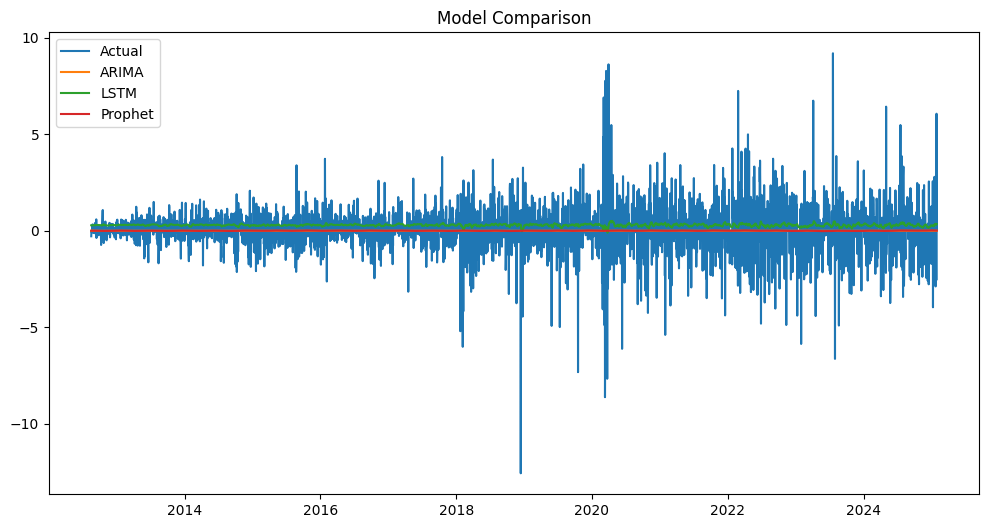

In [36]:
# Adjust the plotting to use the same range for all data
plt.figure(figsize=(12, 6))

# Slice test['Close'] to match the length of predictions for LSTM
plt.plot(test.index[seq_length:], test['Close_diff'].iloc[seq_length:], label='Actual')

plt.plot(test.index[seq_length:], arima_forecast[seq_length:], label='ARIMA')

plt.plot(test.index[seq_length:], predictions[:, 0], label='LSTM')  # Extract the first column of predictions

plt.plot(test.index[seq_length:], forecast['yhat'].iloc[seq_length:], label='Prophet')  # Slice forecast['yhat']

plt.legend()
plt.title('Model Comparison')
plt.show()

In [37]:
# compare the model in tabel form
models = ['ARIMA', 'LSTM', 'Prophet']
maes = [mae_arima, mae_lstm, mae]
rmses = [rmse_arima, rmse_lstm, rmse]


In [38]:
data = {'Model': models, 'MAE': maes, 'RMSE': rmses}
df_compare = pd.DataFrame(data)

print(df_compare)

     Model       MAE      RMSE
0    ARIMA  0.585568  1.080379
1     LSTM  0.705834  1.122864
2  Prophet  0.586795  1.080233
